In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
df = pd.read_csv('tlkm_new.csv', parse_dates=['Date'])

In [4]:
def load_data(company, start, end):
    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.Name == company, :]
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'Close'})
    return dataframe

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2020-12-30,3420.0,3420.0,3310.0,3310.0,2917.152588,150844500,tlkm
1,2021-01-04,3320.0,3500.0,3310.0,3490.0,3075.789307,165339800,tlkm
2,2021-01-05,3480.0,3480.0,3420.0,3470.0,3058.163086,157800700,tlkm
3,2021-01-06,3470.0,3490.0,3330.0,3370.0,2970.031250,177877900,tlkm
4,2021-01-07,3390.0,3450.0,3380.0,3390.0,2987.657715,140221900,tlkm


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
728,2023-12-21,3960.0,3970.0,3930.0,3950.0,3950.0,48242100,tlkm
729,2023-12-22,3980.0,3980.0,3950.0,3960.0,3960.0,28222700,tlkm
730,2023-12-27,3990.0,4000.0,3920.0,3940.0,3940.0,73157200,tlkm
731,2023-12-28,3960.0,3970.0,3940.0,3960.0,3960.0,34024400,tlkm
732,2023-12-29,3960.0,3980.0,3940.0,3950.0,3950.0,27497600,tlkm


In [16]:
COMPANY = 'tlkm'
START_DATE = dt.datetime(2020,12,30)
END_DATE = dt.datetime(2023,6,6)

START_DATE_TEST = END_DATE
END_DATE_TEST = dt.datetime(2023,12,29)

In [17]:
data = load_data(company = COMPANY,
                 start = START_DATE,
                 end = END_DATE)

In [18]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [19]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [20]:
def LSTM_model():
    
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    return model

In [21]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [22]:
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)

model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25
17/17 [==============================] - 17s 103ms/step - loss: 0.0643
Epoch 2/25
17/17 [==============================] - 2s 103ms/step - loss: 0.0147
Epoch 3/25
17/17 [==============================] - 2s 101ms/step - loss: 0.0129
Epoch 4/25
17/17 [==============================] - 2s 109ms/step - loss: 0.0114
Epoch 5/25
17/17 [==============================] - 2s 122ms/step - loss: 0.0129
Epoch 6/25
17/17 [==============================] - 2s 123ms/step - loss: 0.0119
Epoch 7/25
17/17 [==============================] - 2s 109ms/step - loss: 0.0104
Epoch 8/25
17/17 [==============================] - 5s 192ms/step - loss: 0.0094
Epoch 9/25
17/17 [==============================] - 3s 167ms/step - loss: 0.0092
Epoch 10/25
17/17 [==============================] - 4s 144ms/step - loss: 0.0087
Epoch 11/25
17/17 [==============================] - 5s 290ms/step - loss: 0.0100
Epoch 12/25
17/17 [==============================] - 2s 141ms/step - loss: 0.0084
Epoch 13/25
17/17 [=====

In [23]:
test_data = load_data(
    company=COMPANY,
    start=START_DATE_TEST,
    end=dt.datetime(2024,1,12)
)

actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [24]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

5/5 [==============================] - 13s 59ms/step


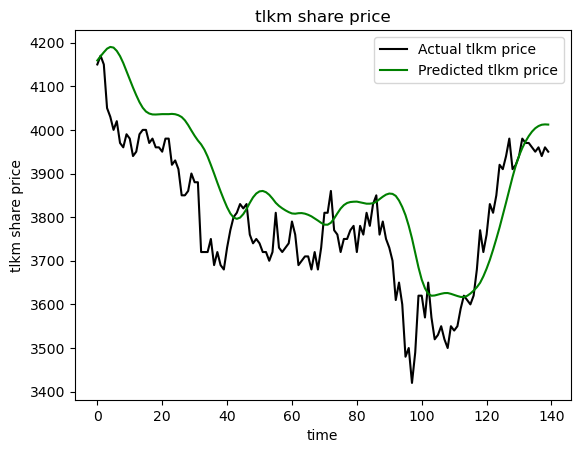

In [25]:
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [29]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 0s 75ms/step
Prediction: 4010.83154296875
